This notebook will implement anomaly detection on the credit card fraud dataset.

See it on Kaggle at this link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [3]:
import pandas as pd

file_path = f"{path}/creditcard.csv"
df = pd.read_csv(file_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
"""
Split into test & train + normalize
"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
"""
Obtain normal & anomalous sets (already scaled!)
Fraud = 1
"""
X_train_normal = X_train_scaled[y_train == 0]
X_train_anomalous = X_train_scaled[y_train == 1]

y_train_normal = y_train[y_train == 0]
y_train_anomalous = y_train[y_train == 1]

X_test_normal = X_test_scaled[y_test == 0]
X_test_anomalous = X_test_scaled[y_test == 1]

y_test_normal = y_test[y_test == 0]
y_test_anomalous = y_test[y_test == 1]

print(len(X_train_normal), len(y_train_normal), "and", type(X_train_normal))
print(len(X_train_anomalous), len(y_train_anomalous), "and", type(X_train_anomalous))

227451 227451 and <class 'numpy.ndarray'>
394 394 and <class 'numpy.ndarray'>


List of possible anomaly detection algorithms:
- LabelEncoder + Support Vector Classifier, as [here](https://www.kaggle.com/code/youssefelbadry10/credit-card-fraud-detection)
- Isolation Forest, as [here](https://www.kaggle.com/code/krippanandhini/credit-card-fraud-detection).
- Random Forest Classifier, as [here](https://www.kaggle.com/code/savird/credit-card-fraud-rf)
- Something else [here](https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now)?

Resource to learn:
- [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest).


For a large range, experimenting with components will take a long time.
Can be up to 40 minutes, due to the curse of dimensionality.

I will subsequently try PCA to make things more efficient.

In any case, it is pretty interesting to analyze various criterion for model error, being the [Akaik Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC) and [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC).

Both compute variants of model likelihood, with a small value being better!

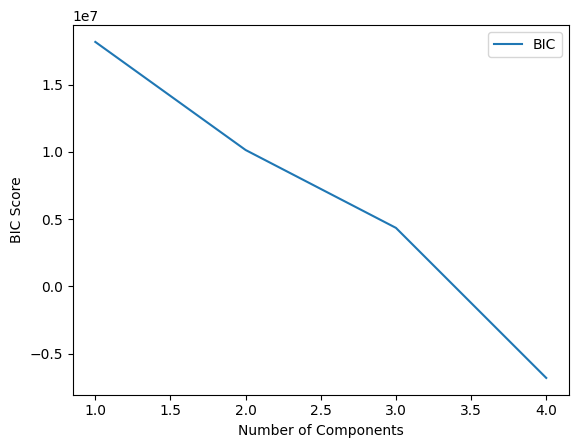

In [ ]:
"""
Clustering using gaussian mixture model
"""
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components = range(1, 5) # Test different number of components
bic_scores = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train_normal)
    bic_scores.append(gmm.bic(X_train_normal))

plt.plot(n_components, bic_scores, label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.legend()

plt.show()

In [ ]:
"""
Using results from experiment to train GMM
"""
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(n_components=9, random_state=42)
gmm.fit(X_train_normal)

print("BIC: ", gmm.bic(X_train_normal))

BIC:  -10145525.17066855


In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Function is compatible only GMM
def auprc_score_gmm(model, normal, anomalous):
  normal_probabilities = model.score_samples(normal)
  anomalous_probabilities = model.score_samples(anomalous)

  all_probabilities = np.concatenate([normal_probabilities, anomalous_probabilities])
  all_labels = np.concatenate([np.zeros(len(normal_probabilities)), np.ones(len(anomalous_probabilities))])

  # Calculate precision, recall, and AUC-PR
  precision, recall, _ = precision_recall_curve(all_labels, all_probabilities * -1)  # Multiplying probabilities by -1 for anomalies
  auc_score = auc(recall, precision)

  # Plot the PR curve
  plt.plot(recall, precision, label=f'AUC-PR = {auc_score:.2f}')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.show()

  return auc_score

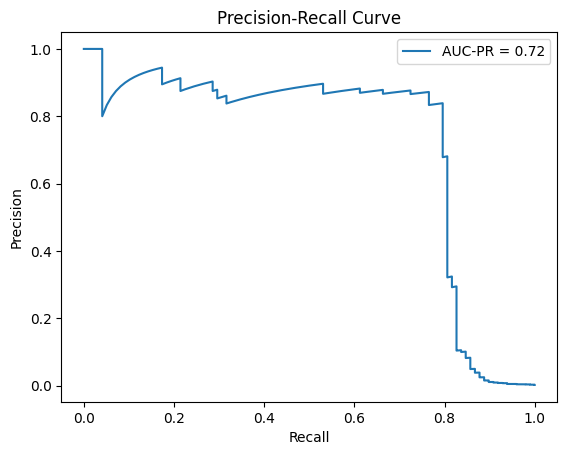

AUC-PR: 0.7225216341374978


In [ ]:
"""
Using AUC PR on GMM
"""
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Receive AUC-PR score
auc_score = auprc_score_gmm(gmm, X_test_normal, X_test_anomalous)
print(f"AUC-PR: {auc_score}")

In [ ]:
"""
Other Gaussian Mixture Model Accuracy Metrics on test set
"""
normal_probabilities = gmm.score_samples(X_test_normal)
anomalous_probabilities = gmm.score_samples(X_test_anomalous)

all_probabilities = np.concatenate([normal_probabilities, anomalous_probabilities])
all_labels = np.concatenate([np.zeros(len(normal_probabilities)), np.ones(len(anomalous_probabilities))])

precision, recall, thresholds = precision_recall_curve(all_labels, all_probabilities * -1)  # Multiplying probabilities by -1 for anomalies
auc_score = auc(recall, precision)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Offset an epsilon to avoid division by zero
best_threshold_index = np.argmax(f1_scores)
threshold = thresholds[best_threshold_index]

predicted_anomalies = (all_probabilities * -1) > threshold  # Instances with scores above the threshold are anomalies.

print("Anomaly threshold is: ", threshold)

# Generate Classification Report
classification_report_str = classification_report(all_labels, predicted_anomalies)
print("Classification Report:\n", classification_report_str)

Anomaly threshold is:  236.17134373663623
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.84      0.79      0.81        98

    accuracy                           1.00     56962
   macro avg       0.92      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962



Finally, an interesting visualization of the data, but downsamples from several hundred thousand to just 2000 just to get a sense of the pattern.

See the clusters?

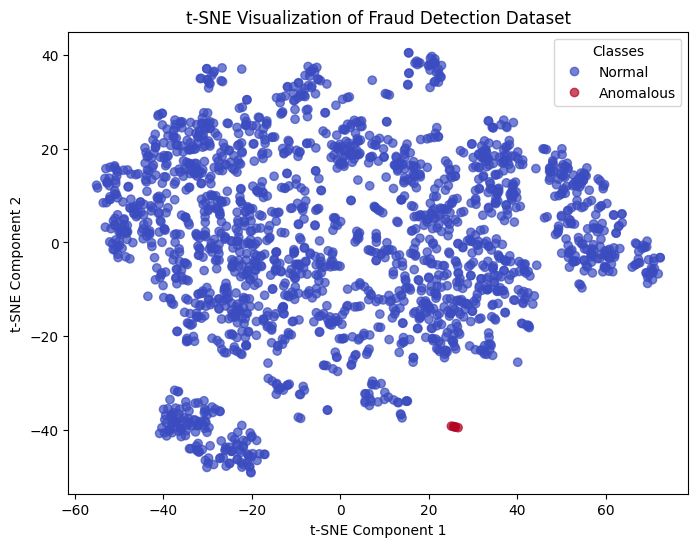

In [ ]:
"""
Applying PCA and T-Distributed Stochastic Neighbors Embedding to make the data suitable for Visualization
"""
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Combine normal and anomalous data for t-SNE visualization
X_all = np.concatenate([X_train_normal, X_train_anomalous], axis=0)
y_all = np.concatenate([y_train_normal, y_train_anomalous], axis=0)

# Apply PCA to reduce dimensions to a smaller size (e.g., 10 or 15 components)
pca = PCA(n_components=15, random_state=42)  # Reduce to 15 components
X_all_pca = pca.fit_transform(X_all)

np.random.seed(42)

# Downsample the data after applying PCA
n_samples = 2000  # Example number of samples to use
indices = np.random.choice(X_all_pca.shape[0], size=n_samples, replace=False)
X_all_pca_downsampled = X_all_pca[indices]
y_all_downsampled = y_all[indices]

# Apply t-SNE to reduce the features from 30 to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_all_pca_downsampled)

# Plotting the t-SNE result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_all_downsampled, cmap='coolwarm', alpha=0.7)
plt.title('t-SNE Visualization of Fraud Detection Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add a legend
legend_elements = scatter.legend_elements()
plt.legend(handles=legend_elements[0], labels=["Normal", "Anomalous"], title="Classes")
plt.show()

Next, we will implement an Random Forest in scikit-learn for the anomaly detection.

In [ ]:
"""
Random Forest Classifier
"""
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

Accuracy: 0.9995611109160493
Confusion Matrix:
 [[56862     2]
 [   23    75]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962



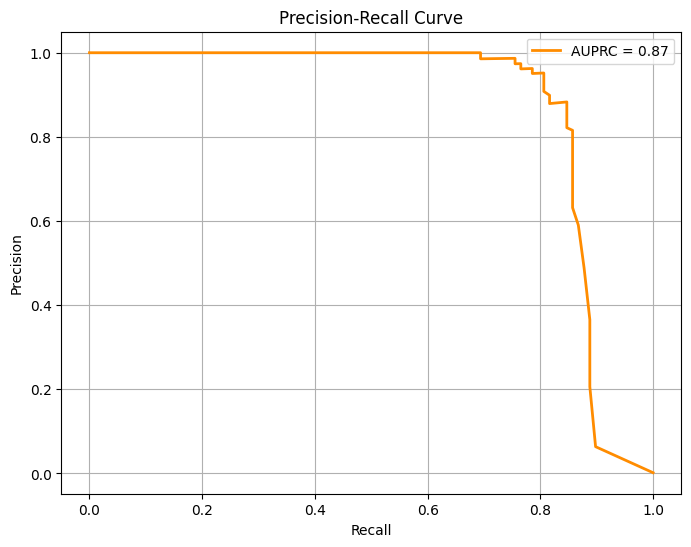

In [ ]:
# Measuring Random Forest Accuracy
# Overall, pretty good!
# Much better AUPRC at 0.87

y_pred = rf_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUPRC = {auprc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [18]:
"""
Winning model: the gradient boosted tree classifier!!
"""
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=10,
    scale_pos_weight=len(y_train_normal) / len(y_train_anomalous),
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model on TEST DATASET
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.83      0.90        98

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962



Tuning anomaly threshold, balancing precision & recall

In [12]:
# Tune the threshold to improve precision/recall balance
threshold = 0.08
y_pred_threshold = (y_pred_prob > threshold).astype(int)

print("Classification Report with adjusted threshold:")
print(classification_report(y_test, y_pred_threshold))

# Check accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Classification Report with adjusted threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.88      0.89        98

    accuracy                           1.00     56962
   macro avg       0.95      0.94      0.95     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9996839998595555


Gauging the model using an Area Under the Precision-Recall Curve, we have a superb score for XGBoost.

<class 'xgboost.sklearn.XGBClassifier'>


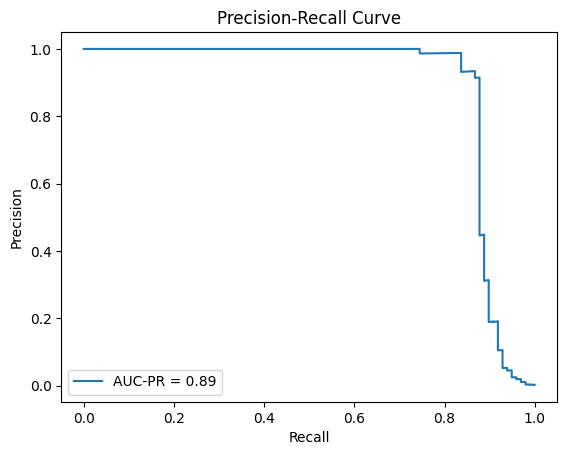

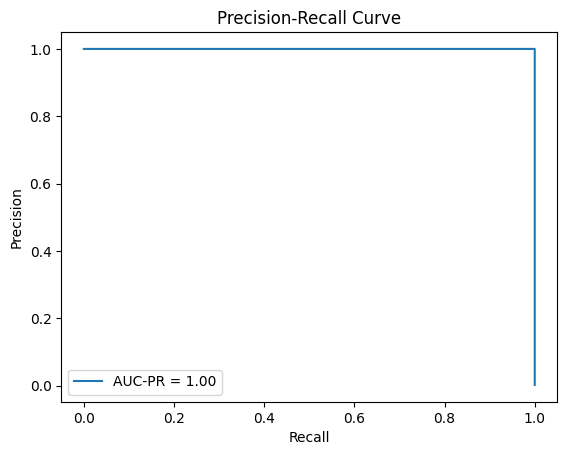

In [20]:
"""
AUC-PR score for XGBoost
"""
from sklearn.metrics import precision_recall_curve, auc
print(type(model))

def auc_plot_xgb(anomalous, normal):
  normal_probabilities = model.predict_proba(normal)[:, 1]
  anomalous_probabilities = model.predict_proba(anomalous)[:, 1]

  all_probabilities = np.concatenate([normal_probabilities, anomalous_probabilities])
  all_labels = np.concatenate([np.zeros(len(normal_probabilities)), np.ones(len(anomalous_probabilities))])

  # Calculate precision, recall, and AUC-PR
  precision, recall, _ = precision_recall_curve(all_labels, all_probabilities)
  auc_score = auc(recall, precision)

  # Plot the PR curve
  plt.plot(recall, precision, label=f'AUC-PR = {auc_score:.2f}')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.show()

auc_plot_xgb(X_test_anomalous, X_test_normal)
auc_plot_xgb(X_train_anomalous, X_train_normal)

---

Basic experiment of a simple GMM from scratch in JAX, which will run very, very fast.

A brief summary:

1. Initialization
- Randomly initialize means, covariances, and weights of Gaussian components.

2. Expectation-Maximization (EM) Algorithm
- E-Step: Compute the probability (responsibilities) of each point belonging to each Gaussian.
- M-Step: Update means, covariances, and weights based on responsibilities
- Repeat until convergence.

3. Anomaly Detection
- Compute log-likelihood for each point.
- Define an anomaly threshold (5th percentile of normal data).
- Flag points with low likelihood as anomalies.

In [9]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, lax
import matplotlib.pyplot as plt

np.random.seed(42)

X_train_normal = jnp.array(X_train_normal)
X_test_normal = jnp.array(X_test_normal)
X_test_anomalous = jnp.array(X_test_anomalous)

# Combine normal and anomalous data for evaluation
X_test = jnp.concatenate([X_test_normal, X_test_anomalous])

# Initialize GMM parameters
num_components = 6  # Reduced components for faster training and demonstration
dim = X_train_normal.shape[1]
key = random.PRNGKey(0)

# Randomly initialize means and covariances (diagonal)
# Use X_train_normal for initialization, important for good starting point
means = jnp.array(X_train_normal[np.random.choice(len(X_train_normal), num_components, replace=False)])
covariances = jnp.array([jnp.var(X_train_normal, axis=0) for _ in range(num_components)])
weights = jnp.ones(num_components) / num_components

# Compute Gaussian probability density function (diagonal covariance)
@jit
def gaussian_pdf_diag(X, mean, cov):
    """
    Computes the Gaussian probability density function with a diagonal covariance matrix.

    Args:
        X: Data points (N x D).
        mean: Mean vector (D).
        cov: Diagonal covariance vector (D).

    Returns:
        Probability density for each data point (N).
    """
    d = X.shape[1]
    precision = 1.0 / cov  # Use precision instead of inverting
    log_det_cov = jnp.sum(jnp.log(cov))
    diff = X - mean
    exponent = -0.5 * jnp.sum(diff**2 * precision, axis=1)
    log_norm_factor = -0.5 * (d * jnp.log(2 * jnp.pi) + log_det_cov)
    return jnp.exp(log_norm_factor + exponent)

# Expectation-Maximization (EM) algorithm
@jit
def gmm_em_diag(X, means, covariances, weights, max_iters=100, tol=1e-3):
    """
    Expectation-Maximization algorithm for Gaussian Mixture Model with diagonal covariance.

    Args:
        X: Training data (N x D).
        means: Initial means (K x D).
        covariances: Initial diagonal covariances (K x D).
        weights: Initial weights (K).
        max_iters: Maximum iterations.
        tol: Tolerance for convergence.

    Returns:
        Updated means, covariances, and weights.
    """
    N = X.shape[0]
    K = means.shape[0]

    def cond_func(carry):
        i, means, covariances, weights, old_log_likelihood = carry
        return i < max_iters

    def body_func(carry):
        i, means, covariances, weights, old_log_likelihood = carry

        # Expectation step
        log_responsibilities = vmap(lambda mean, cov, weight: jnp.log(weight + 1e-12) + jnp.log(gaussian_pdf_diag(X, mean, cov) + 1e-12))(means, covariances, weights)
        log_sum_exp = jax.scipy.special.logsumexp(log_responsibilities, axis=0)
        responsibilities = jnp.exp(log_responsibilities - log_sum_exp)


        # Maximization step
        Nk = jnp.sum(responsibilities, axis=1)
        new_means = (responsibilities @ X) / Nk[:, None]

        # Add a small constant to avoid division by zero
        new_covariances = jnp.array([
            jnp.sum(responsibilities[k, :, None] * (X - new_means[k])**2, axis=0) / Nk[k] + 1e-6
            for k in range(num_components)
        ])
        new_covariances = jnp.clip(new_covariances, 1e-6, None)
        new_weights = Nk / N

        # Calculate log-likelihood to check convergence
        log_likelihood = jnp.sum(log_sum_exp)

        # Check convergence based on log-likelihood
        diff = jnp.abs(log_likelihood - old_log_likelihood)
        means = lax.cond(diff < tol, lambda _: means, lambda _: new_means, None)
        covariances = lax.cond(diff < tol, lambda _: covariances, lambda _: new_covariances, None)
        weights = lax.cond(diff < tol, lambda _: weights, lambda _: new_weights, None)

        return i + 1, means, covariances, weights, log_likelihood

    # Initialize log-likelihood
    initial_log_responsibilities = vmap(lambda mean, cov, weight: jnp.log(weight) + jnp.log(gaussian_pdf_diag(X, mean, cov)))(means, covariances, weights)
    initial_log_sum_exp = jax.scipy.special.logsumexp(initial_log_responsibilities, axis=0)
    initial_log_likelihood = jnp.sum(initial_log_sum_exp)


    init_carry = (0, means, covariances, weights, initial_log_likelihood)
    _, means, covariances, weights, _ = lax.while_loop(cond_func, body_func, init_carry)
    return means, covariances, weights

# Train GMM
means, covariances, weights = gmm_em_diag(X_train_normal, means, covariances, weights)

# Compute log-likelihood for each point in the test set
log_likelihoods = jnp.log(jnp.sum(vmap(lambda mean, cov, weight: weight * gaussian_pdf_diag(X_test, mean, cov))(means, covariances, weights), axis=0))

# Anomaly Detection
threshold = jnp.percentile(log_likelihoods[:len(X_test_normal)], 5)

# Identify anomalies
anomalies = X_test[log_likelihoods < threshold]
normal_identified = X_test[log_likelihoods >= threshold]

print(f"Number of anomalies detected: {len(anomalies)}")

# Create a boolean array indicating which points are truly anomalous
is_anomalous = jnp.concatenate([jnp.zeros(len(X_test_normal)), jnp.ones(len(X_test_anomalous))]).astype(bool)

# Predicted anomalies
predicted_anomalies = log_likelihoods < threshold

# Calculate metrics
true_positives  = jnp.sum(predicted_anomalies & is_anomalous)
false_positives = jnp.sum(predicted_anomalies & ~is_anomalous)
false_negatives = jnp.sum(~predicted_anomalies & is_anomalous)
true_negatives  = jnp.sum(~predicted_anomalies & ~is_anomalous)

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Number of anomalies detected: 2933
Precision: 0.0303
Recall: 0.9082
